In [1]:
'''
AI Assisted GL Mapping
Code Author: Lakshya J
Data set used: "AI_POC - Updated-14May.xlsx"
Main purpose of this project is to visualize the given dataset and apply few Machine Learning libraries
to see which one fits the best for the given set of input data
'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
#Converting the excel file into a pandas dataframe
training_data = pd.read_excel('AI_POC - Updated-14May.xlsx', sheet_name=0, dtype='str')
test_data = pd.read_excel('AI_POC - Updated-14May.xlsx', sheet_name=1)
drop_list=['Taxonomy_Id','Coa_Master_Id','tenant_id','Template_Id','Grouping_Id', 'GL_Nature.1','Level1_Grouping_Id','Level_2_Grouping_Id']
attr=["Description", "Account_Group", "GL_Nature","Level1_Grouping_Id_desc", "Level_2_Grouping_Id_desc", "Reverse_Flag"]
training_data=training_data.drop(drop_list, axis=1)

In [4]:
###Visualisation of data

#Replacing all the missing values with other values
def replace_null(df, col_name,a):
    #Converting all the values of column description as a string object type
    df[col_name]=df[col_name].astype('str')
    df[col_name].fillna(value=a, inplace = True)

attr_test=["Description", "Account_Group","Account_Group_Nature"]
for wrd in attr:
    replace_null(training_data, wrd, "null")
for wrd in attr_test:
    replace_null(test_data,wrd,"null")
    
replace_null(training_data,"Grouping_Id_desc", "null")

In [5]:
#Descriptive Statistics
training_data.describe(include='all')

,Gl_Account_Id,Description,Account_Group,GL_Nature,Grouping_Id_desc,Reverse_Flag,Level1_Grouping_Id_desc,Level_2_Grouping_Id_desc
count,35172,35172,35172,35172,35172,35172,35172,35172
unique,5011,4946,752,4,472,2,98,43
top,Bank Charges,Bank Charges,Trade receivables - other,Asset,"Trade receivables, current, unsecured, conside...",0,Cash and cash equivalents,"Financial Assets, current"
freq,32,48,4527,19379,5517,27929,5308,10716


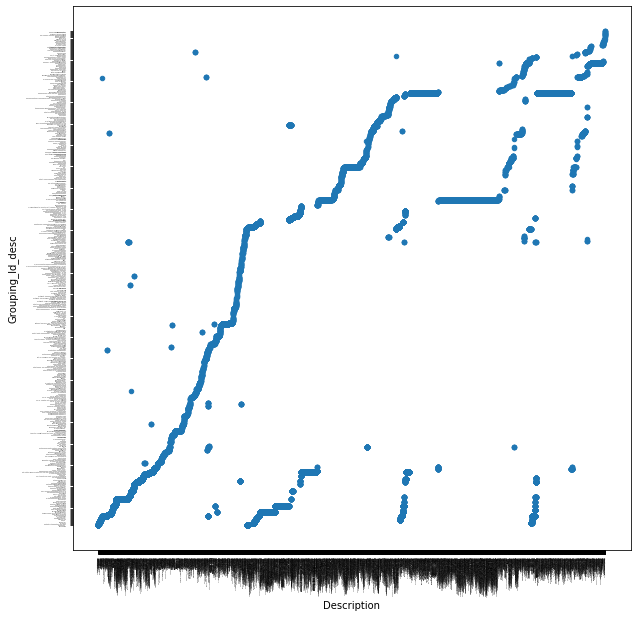

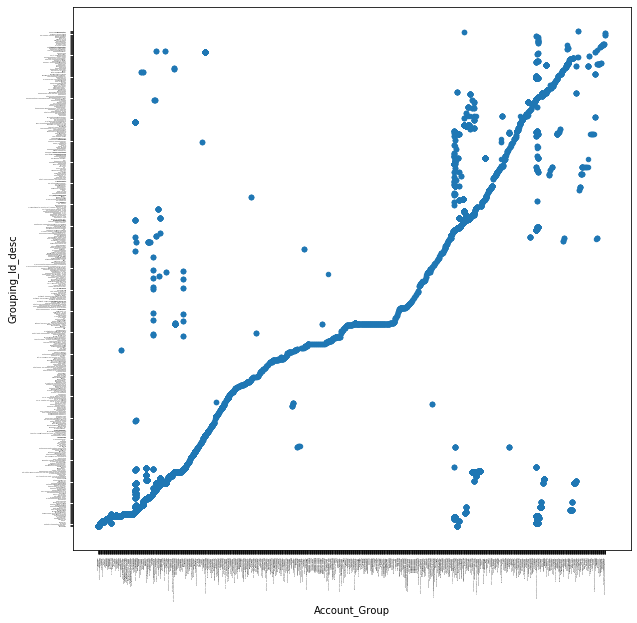

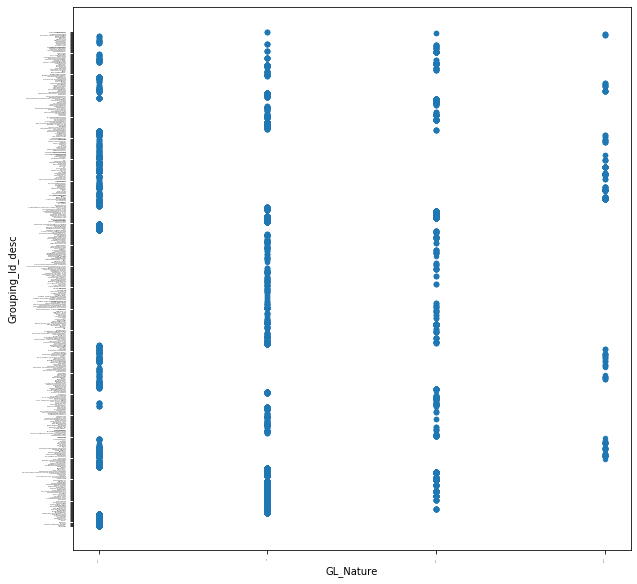

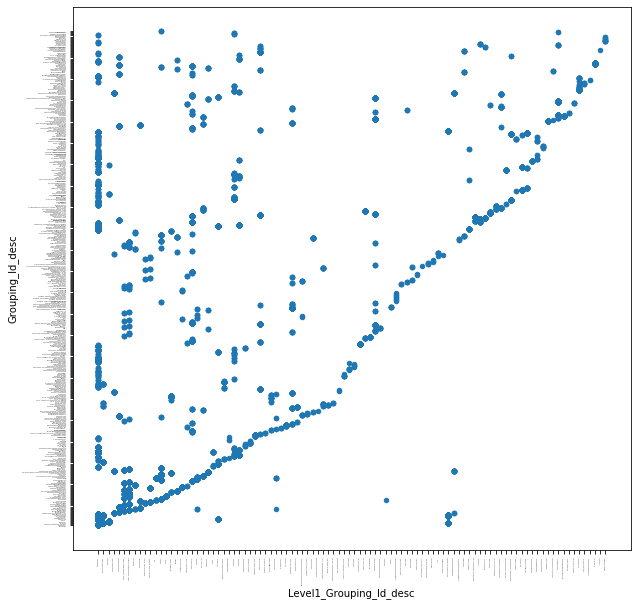

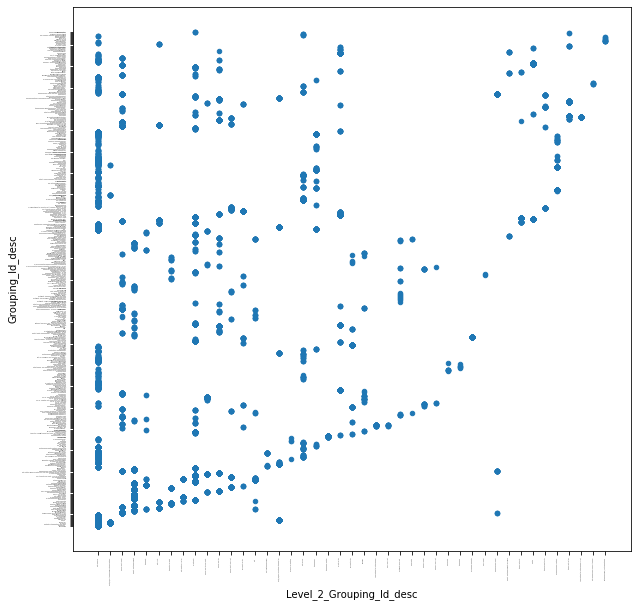

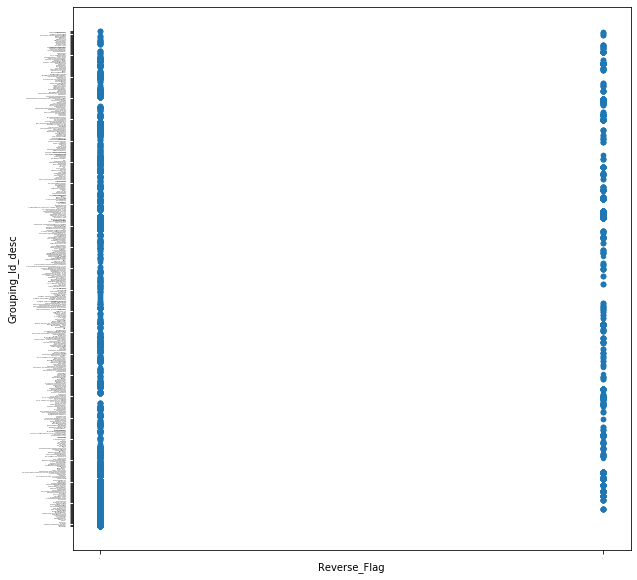

In [6]:
#Inferential Statistics

def scatter_plot(str1):
    training_data.plot.scatter(str1, "Grouping_Id_desc", fontsize=1, figsize=(10,10), rot=90)
    warnings.filterwarnings("ignore", message="Glyph 146 missing from current font.")

for wrd in attr:
    scatter_plot(wrd)

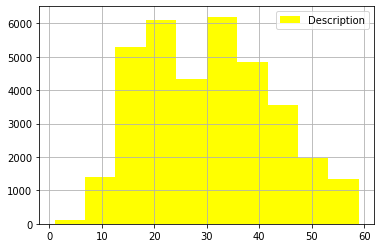

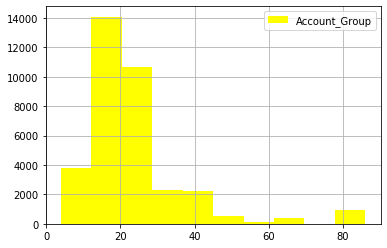

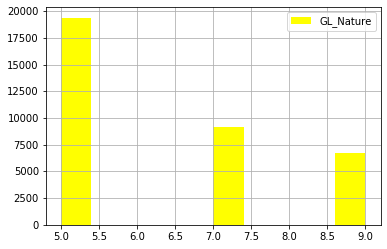

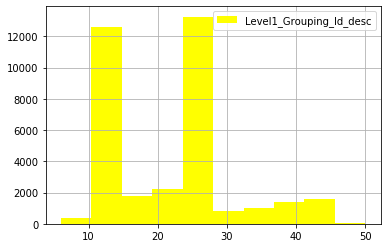

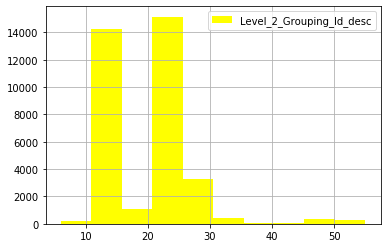

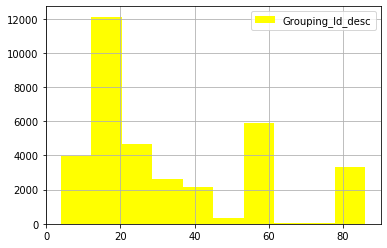

In [7]:
#Exploring fundamental characteristics of the textual data

test_data=test_data.drop(["Gl_Account_Id"], axis=1)
#These plots shpw the number of characters in the data for each of the following data entries.
def length_hist(attr_name):
    training_data[attr_name].str.len().hist(label=attr_name, color='yellow')
    plt.legend()
    plt.show()

for att in attr[:-1]:
    length_hist(att)
length_hist("Grouping_Id_desc")

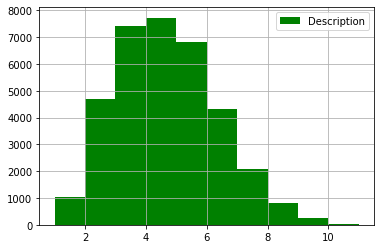

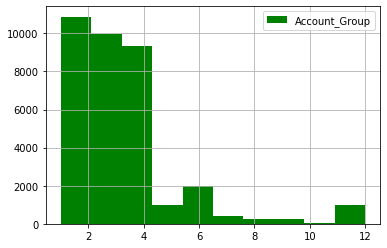

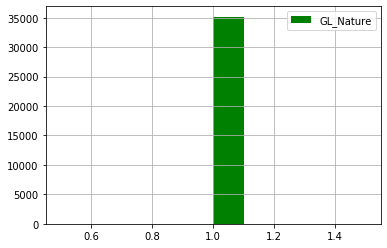

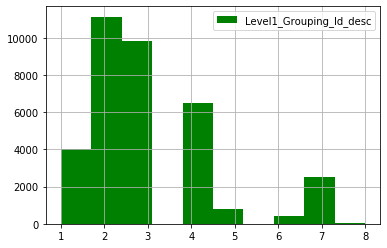

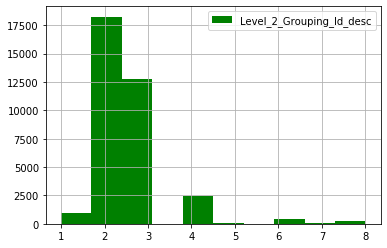

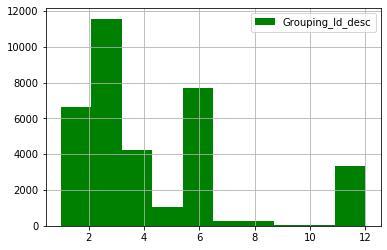

In [8]:
#Histograms showing the number of words in each of the attributes

def word_count_hist(attr_name):
    training_data[attr_name].str.split().map(lambda x: len(x)).hist(label=attr_name,color='green')
    plt.legend()
    plt.show()
    
for att in attr[:-1]:
    word_count_hist(att)
word_count_hist("Grouping_Id_desc")

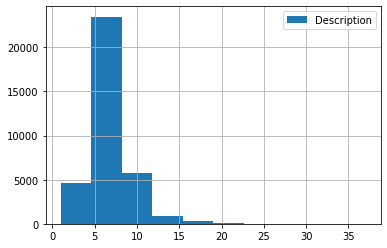

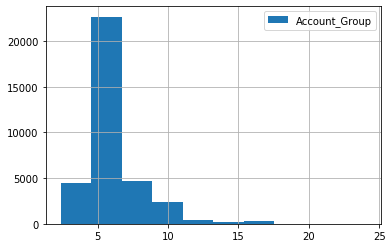

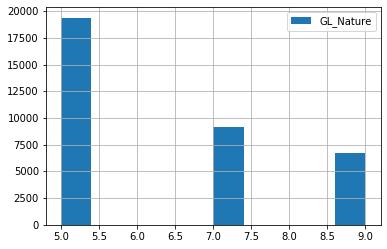

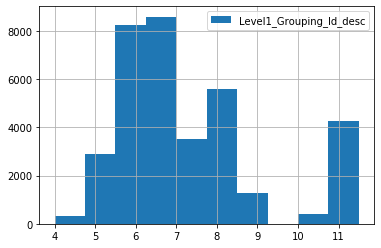

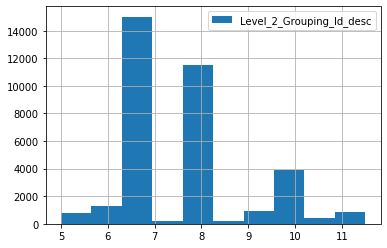

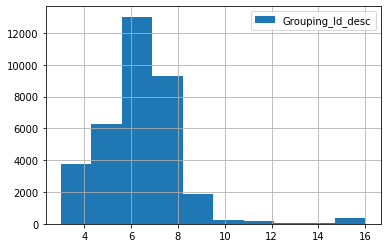

In [9]:
#Histograms showing the average length of each word in each column of the dataframe

def average_word_len(attr_name):
    training_data[attr_name].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(label=attr_name)
    plt.legend()
    plt.show()

for att in attr[:-1]:
    average_word_len(att)
average_word_len("Grouping_Id_desc")

<BarContainer object of 8 artists>

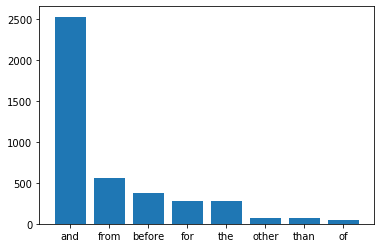

In [10]:
#Plotting the top stopwords and the count of the top stopwords
from collections import defaultdict
stop=set(nltk.corpus.stopwords.words('english'))

corpus=[]
for att in attr[:-1]:
    new= training_data[att].str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

In [12]:
###Pre-processing of the raw data

#Cleanup of data
def cleanup_data(df, attribute_name):
    df[attribute_name]=df[attribute_name].str.lower()
    df[attribute_name].replace('[^A-Za-z ]+', '', regex=True, inplace=True)
    small_words=[' and ', ' from ', ' before ', ' for ', ' the ', ' other ', ' than ', ' of ','than']
    df[attribute_name].replace((word for word in small_words),'',regex=True ,inplace=True)
    df[attribute_name].replace('chg',' charge ',regex=True ,inplace=True)
    df[attribute_name].replace(' loans',' loan ',regex=True ,inplace=True)
    df[attribute_name].replace(' travellg',' travelling ',regex=True ,inplace=True)
    df[attribute_name].replace('  ', ' ', regex=True, inplace=True)
    
#Function call for cleaning up of data
for wrd in attr:
    if wrd!="Reverse_Flag":
        cleanup_data(training_data, wrd)
for wrd in attr_test:
    cleanup_data(test_data,wrd)

#Cleaning up the output column
cleanup_data(training_data, "Grouping_Id_desc")


In [13]:
#Lemmatization of the text data
wordnet_lemmatizer =nltk.stem.WordNetLemmatizer()

def word_lemma(text):
    words=nltk.tokenize.word_tokenize(text)
    words=[wordnet_lemmatizer.lemmatize(w) for w in words if len(w)>2]
    words=sorted(words)
    return " ".join(w for w in words)
    
for att in attr[:-1]:
    training_data[att]=training_data[att].apply(word_lemma)
for att in attr_test:
    test_data[att]=test_data[att].apply(word_lemma)
    
training_data["Grouping_Id_desc"]=training_data["Grouping_Id_desc"].apply(word_lemma)


In [14]:
#Splitting the data points into various columns on the dataframe

#Training Data
x_Description=training_data["Description"].str.split(" ", expand=True)
x_Description.fillna(value="null", inplace=True)
x_Account_Group=training_data["Account_Group"].str.split(" ", expand=True)
x_Account_Group.fillna(value="null", inplace=True)
x_GL_Nature=training_data["GL_Nature"].str.split(" ", expand=True)
x_GL_Nature.fillna(value="null", inplace=True)
training_data_y=training_data["Grouping_Id_desc"]

#Input Test data to apply predictions
x_Description_test=test_data["Description"].str.split(" ", expand=True)
x_Description_test.fillna(value="null", inplace=True)
x_Account_Group_test=test_data["Account_Group"].str.split(" ", expand=True)
x_Account_Group_test.fillna(value="null", inplace=True)
x_GL_Nature_test=test_data["Account_Group"].str.split(" ", expand=True)
x_GL_Nature_test.fillna(value="null", inplace=True)

In [20]:
#Appending all the columns to the dataframe
training_data_x=pd.concat([x_Description,x_Account_Group,x_GL_Nature], axis=1)
training_data_x=training_data_x.astype('str')
training_data_x.columns=np.arange(18)
                         
test_data_x=pd.concat([x_Description_test,x_Account_Group_test,x_GL_Nature_test], axis=1)
test_data_x=training_data_x.astype('str')
test_data_x.columns=np.arange(18)

In [22]:
#Conversion of string values to floats using one hot-encoder technique
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
x=training_data_x.apply(encoder.fit_transform)
x_test=test_data_x.apply(encoder.fit_transform)

In [47]:
###Applying the Random Forest Classifier - Machine Learning Model

#Applying train-test split
x_train, x_test, y_train, y_test = train_test_split(x,training_data_y, test_size=0.33, random_state=42)
#Applying the Classifier
clf=RandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
prediction=clf.predict(x_test)

In [23]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x, training_data_y)
prediction=clf.predict(x_test)

In [27]:
print(prediction)
test_data

['bank charge' 'bank charge' 'bank charge' ...
 'moving provisionslow stock' 'moving provisionslow stock'
 'moving provisionslow stock']


,Description,Account_Group,Account_Group_Nature
0,preference share,issued preference share subscribedpaid,liability
1,equity,equity issued share subscribedpaid,liability
2,subsidy,capital reservers,liability
3,esop outstanding,account employee option outstanding stock,liability
4,prem share,premium security,liability
...,...,...,...
729,indas rent,nan,expense
730,deferred indas tax,nan,nan
731,comprehensive income indas other,nan,nan
732,expenseind interest,nan,expense
